In [ ]:
!unzip -qq "/content/sunflower.zip"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **1. VAE**

(3, 128, 128)
Epoch [0/100], Loss: 0.6682
Epoch [10/100], Loss: 0.6485
Epoch [20/100], Loss: 0.6316
Epoch [30/100], Loss: 0.6250
Epoch [40/100], Loss: 0.6358
Epoch [50/100], Loss: 0.6376
Epoch [60/100], Loss: 0.6357
Epoch [70/100], Loss: 0.6290
Epoch [80/100], Loss: 0.6430
Epoch [90/100], Loss: 0.6321
Average Test Loss: 0.0125


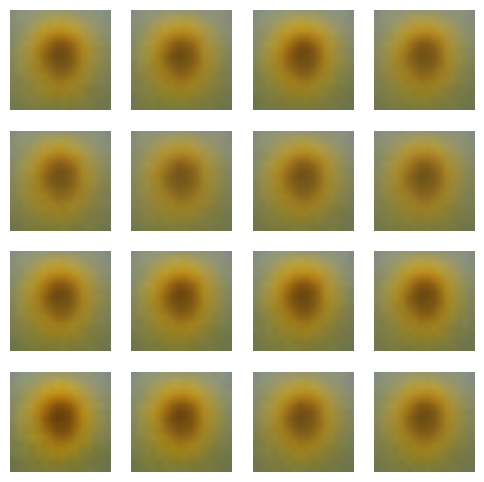

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
# Hyperparameters
batch_size = 64
image_size = 128  # 목표 이미지 크기
latent_size = 100

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터셋 정의
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.file_list[idx])
        image = Image.open(img_name).convert('RGB')  # 흑백 이미지로 변환
        if self.transform:
            image = self.transform(image)
        return image

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

# 전체 데이터셋을 Train Set과 Test Set으로 나누기
dataset = CustomDataset(root_dir='/content/sunflower', transform=transform)
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
print(np.array(train_data[0]).shape)
# 각각의 데이터로더 생성
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

# VAE 모델 정의
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )

        # Latent space
        self.fc_mu = nn.Linear(256 * (image_size // 16) * (image_size // 16), latent_size)
        self.fc_logvar = nn.Linear(256 * (image_size // 16) * (image_size // 16), latent_size)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
            nn.Upsample(size=(image_size, image_size), mode='bilinear', align_corners=False)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        z = z.view(z.size(0), latent_size, 1, 1)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

# 모델 생성
vae = VAE().to(device)

# 손실 함수 및 최적화 함수
criterion = nn.BCELoss()
optimizer = optim.Adam(vae.parameters(), lr=0.002)

def generate_samples(num_samples):
    with torch.no_grad():
        # 랜덤한 잠재 변수 생성
        z = torch.randn(num_samples, latent_size, 1, 1).to(device)

        # 디코더를 통해 이미지 생성
        generated_samples = vae.decoder(z).cpu()

    return generated_samples

# 학습
num_epochs = 100
for epoch in range(num_epochs):
    for data in train_dataloader:
        img = Variable(data).to(device)  # GPU로 데이터 이동

        # Forward pass
        img_recon, mu, logvar = vae(img)

        # Compute reconstruction loss and KL divergence
        reconstruction_loss = criterion(img_recon, img)
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Total loss
        loss = reconstruction_loss + kl_divergence

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print progress for each epoch
    if epoch % 10 == 0:
      print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

# 학습된 모델로부터 이미지 생성 및 시각화
num_generated_samples = 16
generated_samples = generate_samples(num_generated_samples)

# 테스트 데이터로 성능 평가
vae.eval()
test_loss = 0.0
with torch.no_grad():
    for data in test_dataloader:
        img = Variable(data).to(device)  # GPU로 데이터 이동

        # Forward pass
        img_recon, mu, logvar = vae(img)

        # Compute reconstruction loss and KL divergence
        reconstruction_loss = criterion(img_recon, img)
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Total loss
        loss = reconstruction_loss + kl_divergence

        test_loss += loss.item()

# 평균 테스트 손실 출력
average_test_loss = test_loss / len(test_dataloader.dataset)
print(f'Average Test Loss: {average_test_loss:.4f}')

# 이미지 시각화
plt.figure(figsize=(6, 6))
for i in range(num_generated_samples):
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].permute(1, 2, 0).numpy())
    plt.axis('off')

plt.show()


# **GAN Model**


Epoch [0/100], Generator Loss: 2.7174, Discriminator Loss: 0.0355
Epoch [10/100], Generator Loss: 0.6741, Discriminator Loss: 0.3814
Epoch [20/100], Generator Loss: 1.4893, Discriminator Loss: 0.5012
Epoch [30/100], Generator Loss: 1.0637, Discriminator Loss: 0.4305
Epoch [40/100], Generator Loss: 1.2667, Discriminator Loss: 0.7867
Epoch [50/100], Generator Loss: 0.1555, Discriminator Loss: 0.9914
Epoch [60/100], Generator Loss: 1.3401, Discriminator Loss: 0.3409
Epoch [70/100], Generator Loss: 1.3388, Discriminator Loss: 0.3655
Epoch [80/100], Generator Loss: 0.5789, Discriminator Loss: 0.4805
Epoch [90/100], Generator Loss: 1.6704, Discriminator Loss: 0.5557


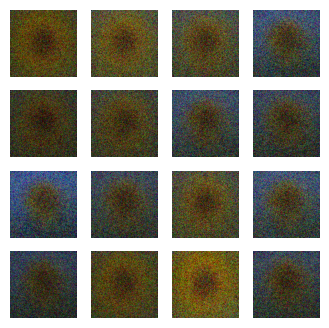

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Hyperparameters
batch_size = 64
image_size = 128  # 목표 이미지 크기
latent_size = 100

# GPU 디바이스를 선택
device_id = 0  # 사용할 GPU의 ID를 설정
device = torch.device("cuda:{}".format(device_id) if torch.cuda.is_available() else "cpu")

# 데이터셋 정의
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.file_list[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

# 전체 데이터셋을 Train Set과 Test Set으로 나누기
dataset = CustomDataset(root_dir='/content/sunflower', transform=transform)
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42, shuffle=True, stratify=None)

# 각각의 데이터로더 생성
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)

# 생성자(Generator) 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_size, 256),
            nn.ReLU(),
            nn.Linear(256, 3 * image_size * image_size),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 3, image_size, image_size)  # 1차원을 3차원으로 reshape

# 판별자(Discriminator) 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3 * image_size * image_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x.view(-1, 3 * image_size * image_size))

# 모델 생성
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# 손실 함수 및 최적화 함수
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

epochs = 100

# 훈련
for epoch in range(epochs):
    for real_images in train_dataloader:
        real_images = real_images.to(device)
        real_labels = torch.ones(real_images.size(0), 1).to(device)

        z = torch.randn(real_images.size(0), latent_size).to(device)

        fake_images = generator(z)
        fake_labels = torch.zeros(real_images.size(0), 1).to(device)

        optimizer_g.zero_grad()
        gen_loss = criterion(discriminator(fake_images), real_labels)
        gen_loss.backward()
        optimizer_g.step()

        optimizer_d.zero_grad()
        real_loss = criterion(discriminator(real_images.view(-1, 3 * image_size * image_size)), real_labels)
        fake_loss = criterion(discriminator(fake_images.detach()), fake_labels)
        disc_loss = 0.5 * (real_loss + fake_loss)
        disc_loss.backward()
        optimizer_d.step()

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], Generator Loss: {gen_loss.item():.4f}, Discriminator Loss: {disc_loss.item():.4f}")

# 생성된 이미지 시각화
with torch.no_grad():
    z = torch.randn(16, latent_size).to(device)
    generated_images = generator(z).cpu().view(-1, 3, image_size, image_size)

plt.figure(figsize=(4, 4))
for i in range(16):
    plt.subplot(4, 4, i+1)

    # 이미지의 픽셀 값 범위를 [0, 1]로 조정
    img = generated_images[i].permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.axis('off')

plt.show()


Epoch [0/100], Generator Loss: 2.8976, Discriminator Loss: 0.0295
Epoch [10/100], Generator Loss: 1.6334, Discriminator Loss: 0.1299
Epoch [20/100], Generator Loss: 0.1986, Discriminator Loss: 0.8956
Epoch [30/100], Generator Loss: 0.8357, Discriminator Loss: 0.5003
Epoch [40/100], Generator Loss: 0.7487, Discriminator Loss: 0.4440
Epoch [50/100], Generator Loss: 1.0907, Discriminator Loss: 0.3565
Epoch [60/100], Generator Loss: 0.8150, Discriminator Loss: 0.4699
Epoch [70/100], Generator Loss: 1.2816, Discriminator Loss: 0.2682
Epoch [80/100], Generator Loss: 1.1886, Discriminator Loss: 0.4491
Epoch [90/100], Generator Loss: 0.7976, Discriminator Loss: 0.3628


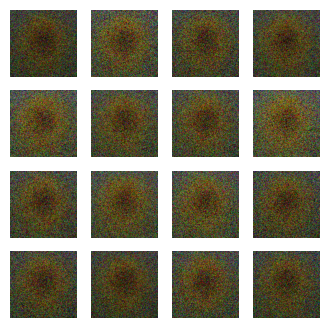

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Hyperparameters
batch_size = 64
image_size = 128  # 목표 이미지 크기
latent_size = 100

# GPU 디바이스를 선택
device_id = 0  # 사용할 GPU의 ID를 설정
device = torch.device("cuda:{}".format(device_id) if torch.cuda.is_available() else "cpu")

# 데이터셋 정의
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.file_list[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

# 전체 데이터셋을 Train Set과 Test Set으로 나누기
dataset = CustomDataset(root_dir='/content/sunflower', transform=transform)
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42, shuffle=True, stratify=None)

# 각각의 데이터로더 생성
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)

# 생성자(Generator) 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_size, 256),
            nn.ReLU(),
            nn.Linear(256, 3 * image_size * image_size),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 3, image_size, image_size)  # 1차원을 3차원으로 reshape

# 판별자(Discriminator) 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3 * image_size * image_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x.view(-1, 3 * image_size * image_size))

# 모델 생성
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# 손실 함수 및 최적화 함수
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

epochs = 100

# 훈련
for epoch in range(epochs):
    for real_images in train_dataloader:
        real_images = real_images.to(device)
        real_labels = torch.ones(real_images.size(0), 1).to(device)

        z = torch.randn(real_images.size(0), latent_size).to(device)

        fake_images = generator(z)
        fake_labels = torch.zeros(real_images.size(0), 1).to(device)

        optimizer_g.zero_grad()
        gen_loss = criterion(discriminator(fake_images), real_labels)
        gen_loss.backward()
        optimizer_g.step()

        optimizer_d.zero_grad()
        real_loss = criterion(discriminator(real_images.view(-1, 3 * image_size * image_size)), real_labels)
        fake_loss = criterion(discriminator(fake_images.detach()), fake_labels)
        disc_loss = 0.5 * (real_loss + fake_loss)
        disc_loss.backward()
        optimizer_d.step()

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], Generator Loss: {gen_loss.item():.4f}, Discriminator Loss: {disc_loss.item():.4f}")

# 생성된 이미지 시각화
with torch.no_grad():
    z = torch.randn(16, latent_size).to(device)
    generated_images = generator(z).cpu().view(-1, 3, image_size, image_size)

plt.figure(figsize=(4, 4))
for i in range(16):
    plt.subplot(4, 4, i+1)

    # 이미지의 픽셀 값 범위를 [0, 1]로 조정
    img = generated_images[i].permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.axis('off')

plt.show()


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0/1000], Generator Loss: 2.9335, Discriminator Loss: 0.0282
Epoch [10/1000], Generator Loss: 0.5746, Discriminator Loss: 0.4352
Epoch [20/1000], Generator Loss: 0.7750, Discriminator Loss: 0.3653
Epoch [30/1000], Generator Loss: 0.5041, Discriminator Loss: 0.5722
Epoch [40/1000], Generator Loss: 0.1532, Discriminator Loss: 1.0046
Epoch [50/1000], Generator Loss: 0.5648, Discriminator Loss: 0.5000
Epoch [60/1000], Generator Loss: 0.8841, Discriminator Loss: 0.4087
Epoch [70/1000], Generator Loss: 0.5893, Discriminator Loss: 0.4559
Epoch [80/1000], Generator Loss: 0.8253, Discriminator Loss: 0.5003
Epoch [90/1000], Generator Loss: 0.4010, Discriminator Loss: 0.5980
Epoch [100/1000], Generator Loss: 0.8240, Discriminator Loss: 0.4523
Epoch [110/1000], Generator Loss: 1.4619, Discriminator Loss: 0.4265
Epoch [120/1000], Generator Loss: 0.6376, Discriminator Loss: 0.4782
Epoch [130/1000], Generator Loss: 1.6575, Discriminator Loss: 0.4111
Epoch [140/1000], Generator Loss: 0.5909, Dis

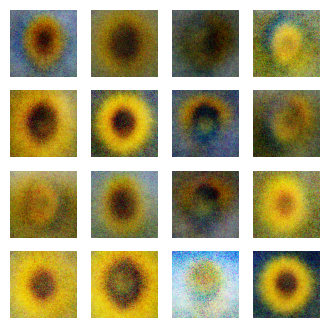

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Hyperparameters
batch_size = 64
image_size = 128  # 목표 이미지 크기
latent_size = 100

# GPU 디바이스를 선택
device_id = 0  # 사용할 GPU의 ID를 설정
device = torch.device("cuda:{}".format(device_id) if torch.cuda.is_available() else "cpu")

# 데이터셋 정의
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.file_list[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

# 전체 데이터셋을 Train Set과 Test Set으로 나누기
dataset = CustomDataset(root_dir='/content/sunflower', transform=transform)
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42, shuffle=True, stratify=None)

# 각각의 데이터로더 생성
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)

# 생성자(Generator) 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_size, 256),
            nn.ReLU(),
            nn.Linear(256, 3 * image_size * image_size),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 3, image_size, image_size)  # 1차원을 3차원으로 reshape

# 판별자(Discriminator) 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3 * image_size * image_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x.view(-1, 3 * image_size * image_size))

# 모델 생성
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# 손실 함수 및 최적화 함수
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

epochs = 1000

# 훈련
for epoch in range(epochs):
    for real_images in train_dataloader:
        real_images = real_images.to(device)
        real_labels = torch.ones(real_images.size(0), 1).to(device)

        z = torch.randn(real_images.size(0), latent_size).to(device)

        fake_images = generator(z)
        fake_labels = torch.zeros(real_images.size(0), 1).to(device)

        optimizer_g.zero_grad()
        gen_loss = criterion(discriminator(fake_images), real_labels)
        gen_loss.backward()
        optimizer_g.step()

        optimizer_d.zero_grad()
        real_loss = criterion(discriminator(real_images.view(-1, 3 * image_size * image_size)), real_labels)
        fake_loss = criterion(discriminator(fake_images.detach()), fake_labels)
        disc_loss = 0.5 * (real_loss + fake_loss)
        disc_loss.backward()
        optimizer_d.step()

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], Generator Loss: {gen_loss.item():.4f}, Discriminator Loss: {disc_loss.item():.4f}")

# 생성된 이미지 시각화
with torch.no_grad():
    z = torch.randn(16, latent_size).to(device)
    generated_images = generator(z).cpu().view(-1, 3, image_size, image_size)

plt.figure(figsize=(4, 4))
for i in range(16):
    plt.subplot(4, 4, i+1)

    # 이미지의 픽셀 값 범위를 [0, 1]로 조정
    img = generated_images[i].permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.axis('off')

plt.show()
